**Глава 3. Преобразования изображений**

Навигация к соседним тетрадям:
<!--NAVIGATION-->
<[Глава 2. Локальные дескрипторы изображений](2_local_image_descriptors.ipynb) | [Содержание](0_index.ipynb) | [Глава 4. Модели камер и дополненная реальность](4_camera_models_and_augmented_relity.ipynb)>

<a href="https://colab.research.google.com/github/mualal/computer-vision-with-python/blob/master/3_image_to_image_mapping.ipynb">    <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Открыть и запустить в Google Colaboratory"></a>

In [1]:
from PIL import Image
import os
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

In [2]:
try:
    import google.colab, sys
    !git clone https://github.com/mualal/computer-vision-with-python.git
    sys.path.append('computer-vision-with-python')
    %cd computer-vision-with-python
except:
    import sys
    sys.path.append('..')

In [3]:
import homography
import warp

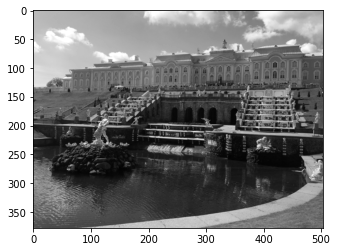

In [4]:
im = np.array(Image.open(os.path.join('images_input', 'Peterhof.jpg')).resize((504, 378)).convert('L'))
plt.gray()
plt.imshow(im)

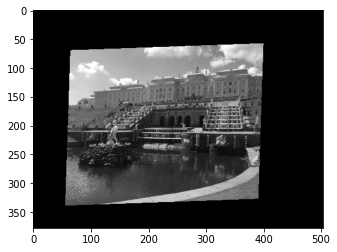

In [5]:
h = np.array([[1.4, 0.05, -100], [0.05, 1.5, -100], [0, 0, 1]])
im2 = ndimage.affine_transform(im, h[:2, :2], (h[0, 2], h[1, 2]))
plt.imshow(im2)

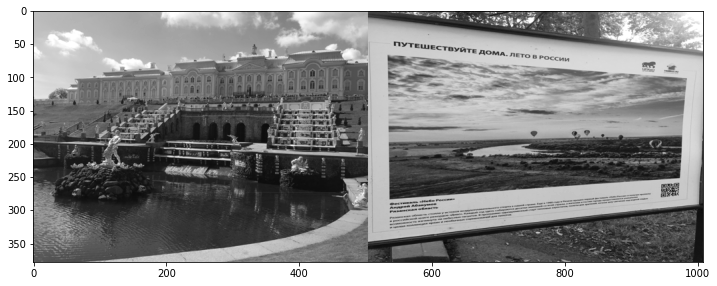

In [6]:
im1 = np.array(Image.open(os.path.join('images_input', 'Peterhof.jpg')).resize((504, 378)).convert('L'))
im2 = np.fliplr(np.array(Image.open(os.path.join('images_input', 'Sky.jpg')).resize((378, 504)).convert('L')).T)
plt.figure(figsize=(12,12))
plt.imshow(np.concatenate((im1, im2), axis=1))

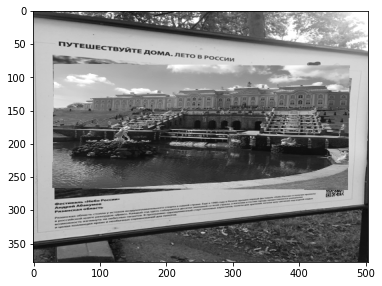

In [7]:
# %matplotlib widget

tp = np.array([[65, 282.8, 253, 99.6], [27.5, 32, 470.6, 480.7], [1, 1, 1, 1]])
im3 = warp.image_to_image(im1, im2, tp)
plt.figure(figsize=(6,6))
plt.imshow(im3)

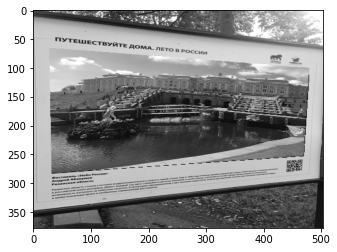

In [8]:
m, n = im1.shape[:2]
fp = np.array([[0, m, m, 0], [0, 0, n, n], [1, 1, 1, 1]])

tp2 = tp[:, :3]
fp2 = fp[:, :3]
h = homography.haffine_from_points(tp2, fp2)
im1_t = ndimage.affine_transform(im1, h[:2, :2], (h[0, 2], h[1, 2]), im2.shape[:2])
alpha = warp.alpha_for_triangle(tp2, im2.shape[0], im2.shape[1])
im3 = (1 - alpha) * im2 + alpha * im1_t

tp2 = tp[:, [0, 2, 3]]
fp2 = fp[:, [0, 2, 3]]
h = homography.haffine_from_points(tp2, fp2)
im1_t = ndimage.affine_transform(im1, h[:2, :2], (h[0, 2], h[1, 2]), im2.shape[:2])
alpha = warp.alpha_for_triangle(tp2, im2.shape[0], im2.shape[1])
im4 = (1 - alpha) * im3 + alpha * im1_t

plt.figure()
plt.imshow(im4)
plt.show()

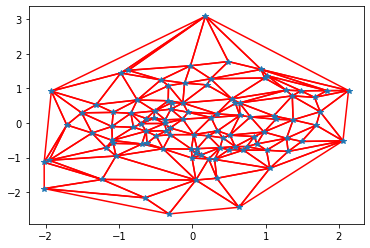

In [9]:
x, y = np.array(np.random.standard_normal((2, 100)))
tri = Delaunay(np.c_[x, y]).simplices

plt.figure()
for t in tri:
    t_ext = [t[0], t[1], t[2], t[0]]
    plt.plot(x[t_ext], y[t_ext], 'r')
plt.plot(x, y, '*')
plt.show()

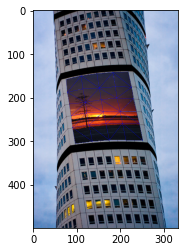

In [10]:
fromim = np.array(Image.open(os.path.join('images_input', 'sunset_tree.jpg')))
x, y = np.meshgrid(range(5), range(6))

x = (fromim.shape[1] / 4) * x.flatten()
y = (fromim.shape[0] / 5) * y.flatten()

tri = warp.triangulate_points(x, y)

im = np.array(Image.open(os.path.join('images_input', 'turningtorso1.jpg')))
tp = np.loadtxt(os.path.join('images_input', 'turningtorso1_points.txt'))

fp = np.vstack((y, x, np.ones((1, len(x)))))
tp = np.vstack((tp[:, 1], tp[:, 0], np.ones((1, len(tp)))))

im = warp.pw_affine(
    from_im=fromim,
    to_im=im,
    from_points=fp,
    to_points=tp,
    tri=tri
)

plt.figure()
plt.imshow(im)
warp.plot_mesh(tp[1], tp[0], tri)
plt.show()

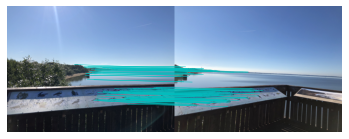

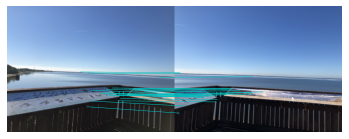

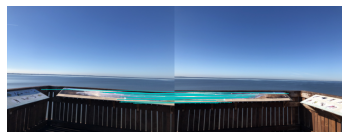

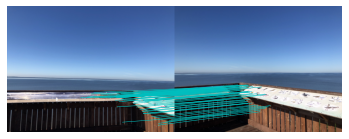

In [11]:
import sift
images = [np.array(Image.open(os.path.join('images_input', f'Kotlin_pan{num}.jpg')).resize((504, 378))) for num in range(1, 6)]

sift_points = [None] * len(images)
descriptors = [None] * len(images)
matches = [None] * len(images)

for i in range(5):
    sift_points[i], descriptors[i] = sift.find_sift_points_and_descriptors(images[i])

for i in range(4):
    matches[i] = sift.match_twosided(descriptors[i], descriptors[i + 1])
    sift.plot_matches(
        images[i],
        images[i + 1],
        [(p.pt[1], p.pt[0]) for p in sift_points[i]],
        [(p.pt[1], p.pt[0]) for p in sift_points[i + 1]],
        matches[i],
        show_below=False
    )


In [12]:
def convert_points(
    j: int
):
    ndx1 = matches[j].nonzero()[0]
    from_points = homography.make_homog(np.array([[p.pt[0], p.pt[1]] for p in sift_points[j + 1][ndx1]]).T)
    ndx2 = [int(matches[j][i]) for i in ndx1]
    to_points = homography.make_homog(np.array([[p.pt[0], p.pt[1]] for p in sift_points[j][ndx2]]).T)
    return from_points, to_points

model = homography.RansacModel()

from_points, to_points = convert_points(1)
h_12 = homography.h_from_ransac(
    from_points,
    to_points,
    model
)[0]

from_points, to_points = convert_points(0)
h_01 = homography.h_from_ransac(
    from_points,
    to_points,
    model
)[0]

to_points, from_points = convert_points(2)
h_32 = homography.h_from_ransac(
    from_points,
    to_points,
    model
)[0]

to_points, from_points = convert_points(3)
h_43 = homography.h_from_ransac(
    from_points,
    to_points,
    model
)[0]


IndexError: index 187 is out of bounds for axis 0 with size 187

<!--NAVIGATION-->
<[Глава 2. Локальные дескрипторы изображений](2_local_image_descriptors.ipynb) | [Содержание](0_index.ipynb) | [Глава 4. Модели камер и дополненная реальность](4_camera_models_and_augmented_relity.ipynb)>

<a href="https://colab.research.google.com/github/mualal/computer-vision-with-python/blob/master/3_image_to_image_mapping.ipynb">    <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Открыть и запустить в Google Colaboratory"></a>